# DecisionTreeClassifier and PCA

In [1]:
# increase the width of the notebook
from IPython.display import display, HTML, Markdown

display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [3]:
# Load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

y_train = train["Score"]
y_test = test["Score"]

X_train = train.drop("Score", axis=1)
X_test = test.drop("Score", axis=1)

## Transformations

In [4]:
from sklearn.pipeline import Pipeline

In [5]:
#Preprocessing pipelines
numeric_features = ["WhiteElo", "EloDif"]
categorical_features = ["Opening_name", "Time_format", "Increment_binary"]

numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

In [6]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed  = preprocessor.transform(X_test)


##  DecisionTree and GridSearch

In [7]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=42)

In [8]:
param_grid = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_transformed, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [9]:
print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy: {:.3f}".format(grid_search.best_score_))

Best parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV accuracy: 0.537


In [10]:
# Evaluate on test set
y_pred = grid_search.predict(X_test_transformed)
print("Test set accuracy: {:.3f}".format(accuracy_score(y_test, y_pred)))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Test set accuracy: 0.527

Classification Report:
               precision    recall  f1-score   support

   Black Win       0.52      0.40      0.45      4524
        Draw       0.00      0.00      0.00       566
   White Win       0.53      0.70      0.61      4910

    accuracy                           0.53     10000
   macro avg       0.35      0.37      0.35     10000
weighted avg       0.50      0.53      0.50     10000



C:\Users\dimit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dimit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dimit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
import joblib

#  Save only the best estimator
best_tree = grid_search.best_estimator_
joblib.dump(best_tree, 'best_decision_tree.joblib')



['best_decision_tree.joblib']

### The accuracy our model achieves is still not great. Let's create a visualization

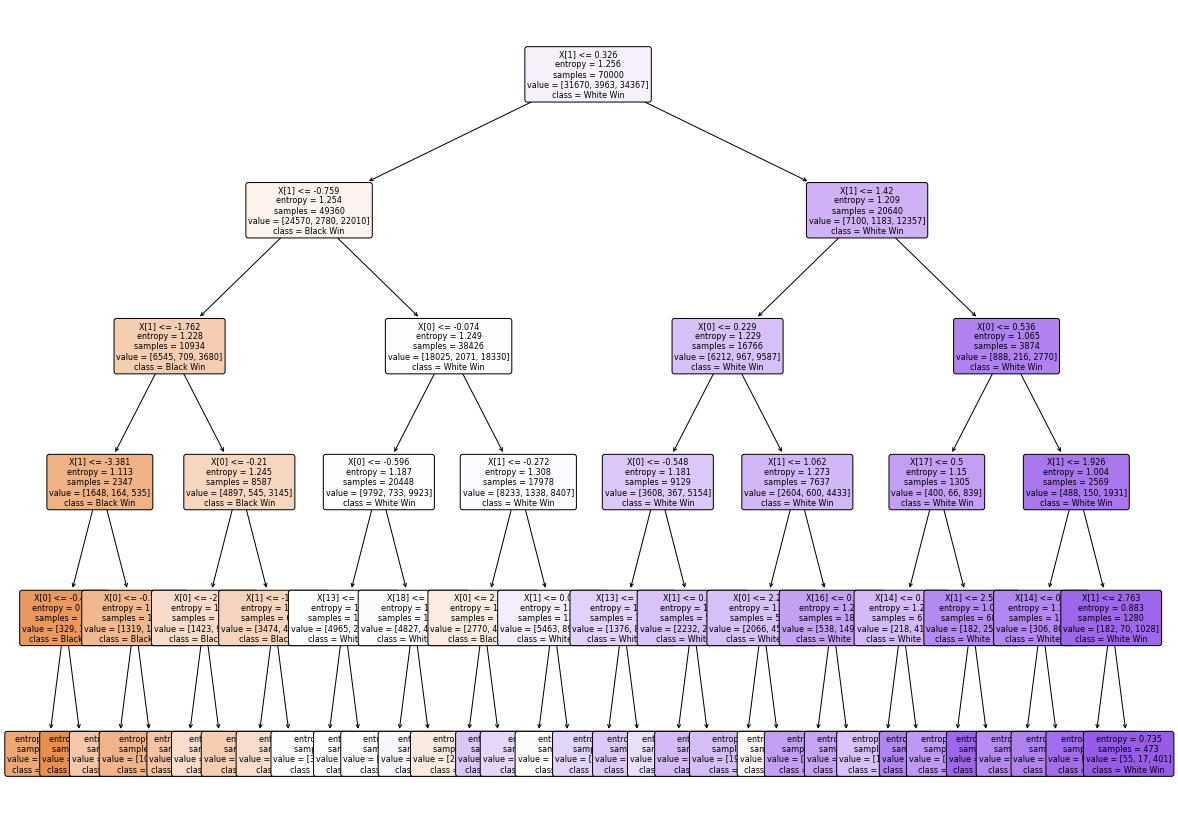

In [12]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Retrieve the best decision tree from the grid search
best_tree = grid_search.best_estimator_

# Class names in the order the tree predicts
class_names = grid_search.classes_

# Plot the tree
plt.figure(figsize=(20, 15))
plot_tree(
    best_tree,
    #feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    fontsize=8
)
plt.show()

## Principal Component Analysis (PCA) 

In [14]:
from sklearn.decomposition import PCA

In [15]:
X_train_dense = X_train_transformed.toarray() if hasattr(X_train_transformed, "toarray") else X_train_transformed
X_test_dense  = X_test_transformed.toarray()  if hasattr(X_test_transformed, "toarray")  else X_test_transformed

In [16]:
pca = PCA(n_components=0.90, random_state=42)
X_train_pca = pca.fit_transform(X_train_dense)
X_test_pca  = pca.transform(X_test_dense)

In [17]:
print(f"Original feature count: {X_train_dense.shape[1]}")
print(f"Reduced feature count:  {X_train_pca.shape[1]} (90% variance)")

Original feature count: 19
Reduced feature count:  8 (90% variance)


In [19]:
grid_search_pca = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_pca.fit(X_train_pca, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 5, 10, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [20]:
# Report results
print("Best parameters (PCA + Tree):", grid_search_pca.best_params_)
print("Best CV accuracy (PCA + Tree): {:.3f}".format(grid_search_pca.best_score_))

y_pred_pca = grid_search_pca.predict(X_test_pca)
print("Test accuracy (PCA + Tree): {:.3f}".format(accuracy_score(y_test, y_pred_pca)))
print("\nClassification Report (PCA + Tree):\n", classification_report(y_test, y_pred_pca))

Best parameters (PCA + Tree): {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV accuracy (PCA + Tree): 0.536
Test accuracy (PCA + Tree): 0.532

Classification Report (PCA + Tree):
               precision    recall  f1-score   support

   Black Win       0.53      0.39      0.45      4524
        Draw       0.00      0.00      0.00       566
   White Win       0.53      0.72      0.61      4910

    accuracy                           0.53     10000
   macro avg       0.36      0.37      0.35     10000
weighted avg       0.50      0.53      0.50     10000



C:\Users\dimit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dimit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dimit\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Applying PCA did not significantly improve our model's accuracy. The resulting score of 0.532 is very close to the performance of a dummy classifier, whereas the original tree classifier achieved a score of 0.527.

In [21]:
# Save only the best estimator
best_tree_pca = grid_search_pca.best_estimator_
joblib.dump(best_tree_pca, 'best_decision_tree_pca.joblib')

['best_decision_tree_pca.joblib']